- Same method as the `0917_ev_model`, 
- different in region size, from toy-model to `real-data`.
- modified the `utilities` based on real reg and ev pricing to distinguish the utilities for both regular and charging parking.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import seaborn as sns
import math
import random

import json
import ast
import copy

random.seed(1209)

from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cmaps

import pickle 
import time

## 1. set the env
- 30 locations
- 24 observing states
    - $\lambda$ = 1/60
- 3 battery levels
- 2 parking 
    - regular parking lot
    - electrical vehicle parking lot

In [2]:
# code the region to number indices. 
nta_index_dict = {
    'MN01':0,'MN03':1,'MN04':2,'MN06':3,'MN09':4,'MN11':5,'MN12':6,'MN13':7,'MN14':8,'MN15':9,\
    'MN17':10,'MN19':11,'MN20':12,'MN21':13,'MN22':14,'MN23':15,'MN24':16,'MN25':17,'MN27':18,'MN28':19,\
    'MN31':20,'MN32':21,'MN33':22,'MN34':23,'MN35':24,'MN36':25,'MN40':26,'MN50':27,'MN99':28,'Others':29
    }
origin_nta_list = list(nta_index_dict.keys())
origin_nta_list.sort()

reverse_nta_dict ={}
for key in nta_index_dict.keys():
    v = nta_index_dict[key]
    reverse_nta_dict[v] = key

In [3]:
STATE_JUMP_RATE = 1/60 # use one hour for each exogenous state
DEPART_RATE = 1/5 
print(round(STATE_JUMP_RATE,3))
REGIONS = [r for r in range(30)] 
STATES = [h for h in range(24)]
DIAGONAL_REGION_PAIRS = [(r,r) for r in REGIONS]
REGION_PAIRS = [(j,i) for j in REGIONS for i in REGIONS]
REST_REGION_PAIRS = [region_pair for region_pair in REGION_PAIRS if region_pair not in DIAGONAL_REGION_PAIRS]

BATTERIES = [0,1,2] # bat: 3 bat levels
V_TYPES = ['REG','EV']

print(f'states: {STATES}')
print(f'regions: {REGIONS}')
# print(f'non-diagonal region pairs:{REST_REGION_PAIRS}')


print("number of regions:{}, number of region pairs:{}, number of non-diagonal region pairs:{}.".format(\
              len(REGIONS), len(REGION_PAIRS), len(REST_REGION_PAIRS)))
print("number of observation states:{}.".format(len(STATES)))
print("number of battery levels:{}.".format(len(BATTERIES)))

0.017
states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
regions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
number of regions:30, number of region pairs:900, number of non-diagonal region pairs:870.
number of observation states:24.
number of battery levels:3.


#### scaler

In [4]:
scaler = 1/(len(REGIONS))
print(scaler)

0.03333333333333333


#### utilities

In [5]:
def convert_keys_to_int(d):
    if isinstance(d, dict):
        new_dict = {}
        for k, v in d.items():
            if k == 'REG' or k =='EV':
                new_key = k  # remain
                new_dict[new_key] = convert_keys_to_int(v)
            else:
                new_key = int(k)  # Convert the key to integer
                new_dict[new_key] = convert_keys_to_int(v)
        return new_dict
    else:
        return d


with open(f'data/data/utility_simulate/UTILITY_reg_ev_v1_estimated_3_092502', 'r') as infile:
    u = json.load(infile)
UTILITY = convert_keys_to_int(u) 
# UTILITY[state]['REG'][region]

#### initial vehicel distribution
- total EV: 300,000

In [6]:
with open('data/data/veh_simulate/veh_searching_scaled_hour0.pkl', 'rb') as file: 
    S0 = pickle.load(file) 
with open('data/data/veh_simulate/veh_parked_scaled_hour0.pkl', 'rb') as file: 
    P0 = pickle.load(file) 
with open('data/data/veh_simulate/veh_transit_scaled_hour0.pkl', 'rb') as file: 
    T0 = pickle.load(file) 
    
# set the heterogeneity aside for now
for k,v in S0.items():
    S0[k] = sum(S0[k].values())
    P0[k] = sum(P0[k].values())
for k,v in T0.items():
    T0[k] = sum(T0[k].values())

    
for region in REGIONS:
    temp = P0[region] + S0[region]
    if region == REGIONS[-1]:
        P0[region] = math.ceil(temp*0.95)
        S0[region] = temp - P0[region]
    else:
        P0[region] = math.ceil(temp*(random.uniform(0.88,0.90)))
        S0[region] = temp - P0[region]

print(sum(S0.values())+sum(P0.values())+sum(T0.values()))

# set the initial vehicle distribution for regular and ev parking lot
### probs for choosing reg:
prob_reg = {region:0 for region in REGIONS}
new_s0 = {region:{'EV': 0,'REG':0} for region in REGIONS}
new_p0 = {region:{'EV': 0,'REG':0} for region in REGIONS}

for region in REGIONS:
    prob_reg[region] = np.exp(UTILITY[0]['REG'][region])/(np.exp(UTILITY[0]['REG'][region]) + np.exp(UTILITY[0]['EV'][region]))
    new_s0[region]['REG'] = math.floor(S0[region]*prob_reg[region])
    new_s0[region]['EV'] = S0[region] - new_s0[region]['REG']
    new_p0[region]['REG'] = math.floor(P0[region]*prob_reg[region])
    new_p0[region]['EV'] = P0[region] - new_p0[region]['REG']

300000.0


#### travel time
- processed the API data

In [7]:
# travel time:
# -use the column of duration_minutes
ar = pd.read_csv('data/data/ev/model_input/arrival_rate.csv', index_col = 0)
ar['Origin'] = ar['origin_nta'].map(nta_index_dict)
ar['Destination'] = ar['destination_nta'].map(nta_index_dict)


# travel time, unit: minutes
T_IJ = {state:{region_pair: 0 for region_pair in REGION_PAIRS} for state in STATES}

for region_pair in REGION_PAIRS:
    for state in STATES:
        T_IJ[state][region_pair] =  ar[(ar['Origin'] == region_pair[0])&(\
                  ar['Destination'] == region_pair[1])&(ar['start_hour'] == state)].iloc[0]['duration_minutes']

#### others

In [8]:
# ################################
# ## set stuck parking price
# ################################
S_ADJUST = 0.4

s_scale = [round(random.uniform(0.85,1.25),2)  for ii in range(len(REGIONS))]
STUCK_PRICE = {state:{region: 0 for region in REGIONS}  for state in STATES} 
for state in STATES:
    for region in REGIONS:
        STUCK_PRICE[state][region] = round(s_scale[region]*S_ADJUST*np.abs(UTILITY[state]['REG'][region])+random.uniform(-0.005,0.005),3)

        
################################
## set parking lots and vehicles (assume its large right now)
################################
N_P = {'EV':{region: random.randint(50000,60000) for region in REGIONS} , 
       'REG': {region: random.randint(50000,60000) for region in REGIONS}  
      }
print(sum(N_P['EV'].values())+sum(N_P['REG'].values()))

3265820


## 2. set the model
- $N^e$  : total number of electrical vehicles
- $N^p$  : total number of parking lots
- $\lambda^r_{ij} (x)$ : arrival rate for each OD-pair for each state x
- $u_{i} (x)$ : utility earned at region i for each state x
- $p^a_i (x)$ : parking price at region i for each state x for parking lot type a
- $\tilde{p}^a_i (x)$ : prob for searching at region i for each state x for parking lot type a
- $p^a_{ij} (x)$ : departure prob from region i to region j for each state x for parking lot type a

In [9]:
def matching_function(region, state, v_type, vehicles, match_efficiency = 0.85, importance_searching = 0.5):
    
    available_spaces = max(N_P[v_type][region] - vehicles[state]['parked'][v_type][region],0)
    s_veh = max(vehicles[state]['searching'][v_type][region],0)
    
    return min(available_spaces,s_veh)*match_efficiency

#searching_rates[state][v_type][region] = matching_function(region, state,v_type, elec_vehicles)

In [10]:
# \tilde_P^a

def searching_probability(region, state, v_type, searching_r, vehicles):
    if vehicles[state]['searching'][v_type][region] != 0:
        return searching_r[state][v_type][region]/vehicles[state]['searching'][v_type][region]
    else:
        return 0
    
# searching_probs[state][v_type][region] = searching_probability(region, state, v_type, searching_rates, elec_vehicles)

In [11]:
# P^a
def charging_probability(search_v, region, state, v_type):
    exp_sum = np.exp(search_v[state]['EV'][region]) + np.exp(search_v[state]['REG'][region])
    if v_type == 'EV':
        return np.exp(search_v[state]['EV'][region])/exp_sum
    else:
        return np.exp(search_v[state]['REG'][region])/exp_sum
    
# charging_probs[state][v_type][region] = charging_probability(search_values, region, state, v_type)

In [12]:
# departure_probability, P_{ij}^a

def exp_sum_transition_v(transit_v, parked_v, region, state, v_type):
    temp_v = 0
    for pair in REGION_PAIRS:
        if pair[0] == region:
            if pair[1] == region:
                temp_v += np.exp(parked_v[state][v_type][pair]) 
            else:
                temp_v += np.exp(transit_v[state]['GEN'][pair])
        
    return temp_v

# sum_v =  exp_sum_transition_v(transit_values, parked_values, region, state, v_type)
# transit_probs[state][v_type][(region,dest)] = np.exp(bar_transit_values[state][v_type][(region,dest)])/sum_v

In [13]:
# arriving_probability, \hat_P_{ij}

def arriving_probability(state, region_pair):
    return max(1 - T_IJ[state][region_pair]*STATE_JUMP_RATE, 0)

# arriving_probs[state][region_pair] = arriving_probability(state, region_pair)

## 3. calculate the values
- $a \in \mathcal{A} = \{r,e\}$ : regular or electrical vehicles
- $b \in \mathcal{B}$: battery levels
-
- $n_i^{a} (x,b) $ : number of a certain type of vehicles parked at state x with battery level b.
- $\tilde{n}_i^{a} (x,b) $ : averaged number of a certain type of vehicles searching for parking at state x with battery level b.
- $n_{ij}^{a} (x,b) $ : number of a certain type of vehicles transit from origin i to destination j  at state x with battery level b.
-

- $V_i^{a} (x,b)$: value for parking/activity in region i at state x with battery level b.
- $V_{ij}^{a} (x,b)$: value for transit from i to j  at state x ($ i \neq j$) with battery level b.
- $\bar{V}_{ij}^{a} (x,b)$: value for transit from i to j  at state x (including both $i \neq j $ and $ i = j$ ) with battery level b.
- $\tilde{\lambda}_i^{a} (x,b) = M_i (.,.)$ : rate for vehicles searching for parking to find parking at state x 
- $\tilde{V}_i^{a} (x,b)$: value for searching for parking in region i at state x with battery level b.
- 
- $P_{ij} (x,b)$ : the probability of moving from i to j at state x with battery level b.
- $P_{i}^a (x,b)$: the probability of charging in parking lot $a$ at state x with battery level b.

In [14]:
## solving V_i^a

def parked_coefficent_matrix():
    
    coef_lists = [[0]*(len(STATES)) for state in STATES]
    
    for ii in range(len(coef_lists)):
        coef_lists[ii][ii] = 1
        if ii < len(coef_lists)-1:
            coef_lists[ii][ii+1] = -STATE_JUMP_RATE/(STATE_JUMP_RATE + DEPART_RATE)                  
        
    return coef_lists

def parked_vectors(region, transit_v, parked_v, v_type):
    vector_list =[]
    
    for state in STATES:
        temp_v = exp_sum_transition_v(transit_v, parked_v, region, state, v_type)
        a1 = 1/(STATE_JUMP_RATE + DEPART_RATE) 
        a2 = np.log(temp_v)*DEPART_RATE
        vec = a1*(UTILITY[state][v_type][region] + a2)
       
        vector_list.append(vec)
        
    return vector_list

def solve_parked_value(scaler, arbitary_value, region, transit_v, parked_v, v_type):
    
    coef = np.array(parked_coefficent_matrix())
    vec = np.array(parked_vectors(region, transit_v, parked_v, v_type))
    x = np.linalg.solve(coef, vec)
    
    
    for ii in range(len(x)):
        x[ii] = (x[ii] - arbitary_value)*scaler
    
    return x

In [15]:
## solving \tilde_V_i^a

def searching_coefficent_matrix(region, searching_p, v_type):
    
    coef_lists = [[0]*(len(STATES)) for state in STATES]
    for ii in range(len(coef_lists)):
        coef_lists[ii][ii] = 1
        if ii < len(coef_lists)-1:
            coef_lists[ii][ii+1] = -STATE_JUMP_RATE/(STATE_JUMP_RATE + searching_p[ii][v_type][region]*DEPART_RATE)
                    
    return coef_lists


def searching_vectors(region, parked_v, searching_p, v_type):
    vector_list =[]
    
    for state in STATES:
        s_rate = searching_p[state][v_type][region]*DEPART_RATE
        if v_type == 'REG':
            a = -STUCK_PRICE[state][region]/(STATE_JUMP_RATE + s_rate)
        else:
            a = 0
        vec = s_rate/(STATE_JUMP_RATE + s_rate)*parked_v[state][v_type][(region,region)] + a 
        vector_list.append(vec)
    
    return vector_list


def solve_searching_values(scaler, arbitary_value, region, parked_v, searching_p, v_type):
    coef = np.array(searching_coefficent_matrix(region, searching_p, v_type))
    vec = np.array(searching_vectors(region, parked_v, searching_p, v_type))
    x = np.linalg.solve(coef, vec)
    
    for ii in range(len(x)):
        x[ii] = (x[ii] - arbitary_value)*scaler
    
    return x

In [16]:
def general_searching_values(search_v, region, state):
    return max(search_v[state]['EV'][region], search_v[state]['REG'][region])

#search_values[state]['GEN'][region] = general_searching_values(search_values, region, state)

In [17]:
## solving for V_{ij}

def transiting_coefficent_matrix(region_pair, arriving_p):
    
    coef_lists = [[0]*(len(STATES)) for state in STATES]
    for ii in range(len(coef_lists)):
        coef_lists[ii][ii] = 1
        if ii < len(coef_lists)-1:
            coef_lists[ii][ii+1] = -STATE_JUMP_RATE/(STATE_JUMP_RATE + arriving_p[ii][region_pair]*DEPART_RATE)
                        
    return coef_lists


def transiting_vectors(region_pair, arriving_p, search_v):
    
    vector_list =[]
    for state in STATES:
        a_rate = arriving_p[state][region_pair]*DEPART_RATE
        vec = a_rate/(STATE_JUMP_RATE + a_rate)*search_v[state]['GEN'][region_pair[1]] 
        vector_list.append(vec)
    
    return vector_list


def solve_transiting_values(scaler, arbitary_value, region_pair, arriving_p, search_v):
    coef = np.array(transiting_coefficent_matrix(region_pair,arriving_p))
    vec = np.array(transiting_vectors(region_pair, arriving_p, search_v))
    x = np.linalg.solve(coef, vec)
    
    for ii in range(len(x)):
        x[ii] = (x[ii] - arbitary_value)*scaler
        
    return x

## 4. calculate vehicle movements

In [18]:
dest_pairs = [(dest,ori) for ori in REGIONS for dest in REGIONS  if ori != dest]  
type_dict = {'REG':0,'EV':1}
types = 2 # reg:0, elec:1
units = types*len(REGIONS)

In [19]:
# veh matrix: square matrix with order of "parked(r,e) + searching(r,e) + transiting (dest_pairs)"

def vehicles_coefficent_matrix(state,  searching_p, charging_p, arriving_p, transit_p):
    
    size = len(REGIONS)*(2*types+len(REGIONS)-1)
    coef_lists = [[0]* size for ii in range(size)]
    
    # 1. set coef for searching vehicles to solve equations for parked vehicles
    for p in REGIONS:
        for v_type in V_TYPES:
            row_idx = p*types+type_dict[v_type]
            # parking:
            coef_lists[row_idx][row_idx] = (\
                      STATE_JUMP_RATE+(1-transit_p[state][v_type][(p,p)])*DEPART_RATE)/transit_p[state][v_type][(p,p)]
            # searching:
            col_idx = row_idx + units
            coef_lists[row_idx][col_idx] = -(\
                      STATE_JUMP_RATE+DEPART_RATE)*searching_p[state][v_type][p]/(1-searching_p[state][v_type][p])
    
    
    # 2. set coef for transiting vehicles to solve equations for searching vehicles
    for s in REGIONS:
        for v_type in V_TYPES:
            row_idx = s*types+type_dict[v_type]+units
            # searching:
            coef_lists[row_idx][row_idx] = (\
                      STATE_JUMP_RATE+searching_p[state][v_type][s]*DEPART_RATE)/(1-searching_p[state][v_type][s])
            # transiting:
            for ii, pair in enumerate(dest_pairs):
                if s == pair[1]:
                    col_idx = 2*units + ii
                    coef_lists[row_idx][col_idx] = -(\
                        STATE_JUMP_RATE+DEPART_RATE\
                        )*charging_p[state][v_type][pair[0]]*arriving_p[state][pair]/(1-arriving_p[state][pair])

    
    # 3.set coef for parked vehicles to solve equations for transiting vehicles
    for ii, pair in enumerate(dest_pairs):
        row_idx = ii+2*units
        coef_lists[row_idx][row_idx] = (STATE_JUMP_RATE+arriving_p[state][pair]*DEPART_RATE)/(1-arriving_p[state][pair])
        for v_type in V_TYPES:
            col_idx = pair[0]*types+type_dict[v_type]
            coef_lists[row_idx][col_idx] = -(\
                STATE_JUMP_RATE+DEPART_RATE)/transit_p[state][v_type][(pair[0],pair[0])]*transit_p[state][v_type][pair]
                        
    return coef_lists


In [20]:
def vehicles_vectors(state, vehicles):
    
    vector_list =[]
    # 1. vec for parked vehicles
    for p in REGIONS:
        for v_type in V_TYPES:
            vector_list.append(STATE_JUMP_RATE*vehicles[state-1]['parked'][v_type][p])
    
    # 2. vec for searching vehicles
    for s in REGIONS:
        for v_type in V_TYPES:
            vector_list.append(STATE_JUMP_RATE*vehicles[state-1]['searching'][v_type][s])
    
    # 3. vec for transiting vehicles
    for pair in dest_pairs:
        vector_list.append(STATE_JUMP_RATE*vehicles[state-1]['transiting'][pair])

    return vector_list

In [21]:
def solve_vehicles(state, searching_p, charging_p, arriving_p, transit_p, vehicles):
    coef = np.array(vehicles_coefficent_matrix(state, searching_p, charging_p, arriving_p, transit_p))
    vec = np.array(vehicles_vectors(state, vehicles))
    x = np.linalg.solve(coef, vec)
    return x

## 5. set initial vehicle distributions

In [22]:
# electrical vehicles
# use the initial veh distribution.
elec_vehicles = { state: {'parked':{'EV':{0: 2158.0, 1: 2693.0, 2: 2732.0, 3: 1467.0, 4: 3150.0, 5: 2157.0, 6: 3123.0, 7: 2515.0, 8: 6091.0, 9: 4174.0, 10: 4740.0, 11: 2095.0, 12: 4850.0, 13: 2130.0, 14: 664.0, 15: 2396.0, 16: 3935.0, 17: 3636.0, 18: 3962.0, 19: 2758.0, 20: 5826.0, 21: 2744.0, 22: 1687.0, 23: 1920.0, 24: 4120.0, 25: 2201.0, 26: 7165.0, 27: 2867.0, 28: 3918.0, 29: 6243.0},
                                    'REG':{0: 7373, 1: 6119, 2: 6391, 3: 5948, 4: 6457, 5: 6941, 6: 4975, 7: 6142, 8: 2979, 9: 3100, 10: 3396, 11: 5453, 12: 2050, 13: 6166, 14: 5366, 15: 5671, 16: 4366, 17: 5295, 18: 4862, 19: 5570, 20: 3484, 21: 4647, 22: 7618, 23: 7055, 24: 5342, 25: 7837, 26: 1787, 27: 2983, 28: 3671, 29: 6865}},
    
                          'searching':{'EV':{0: 105.0, 1: 294.0, 2: 97.0, 3: 508.0, 4: 107.0, 5: 212.0, 6: 667.0, 7: 235.0, 8: 859.0, 9: 1557.0, 10: 1373.0, 11: 674.0, 12: 1971.0, 13: 431.0, 14: 257.0, 15: 550.0, 16: 949.0, 17: 399.0, 18: 627.0, 19: 317.0, 20: 366.0, 21: 946.0, 22: 135.0, 23: 235.0, 24: 383.0, 25: 55.0, 26: 702.0, 27: 1018.0, 28: 1228.0, 29: 412.0},
                                    'REG':{0: 357, 1: 667, 2: 225, 3: 2059, 4: 219, 5: 682, 6: 1061, 7: 573, 8: 420, 9: 1156, 10: 983, 11: 1753, 12: 833, 13: 1245, 14: 2077, 15: 1301, 16: 1051, 17: 580, 18: 769, 19: 639, 20: 218, 21: 1602, 22: 607, 23: 861, 24: 495, 25: 195, 26: 174, 27: 1059, 28: 1149, 29: 452}},
                          
                          'transiting':{(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0, (0, 19): 0, (0, 20): 0, (0, 21): 0, (0, 22): 0, (0, 23): 0, (0, 24): 0, (0, 25): 0, (0, 26): 0, (0, 27): 0, (0, 28): 0, (0, 29): 1, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): 0, (1, 22): 0, (1, 23): 0, (1, 24): 0, (1, 25): 0, (1, 26): 0, (1, 27): 0, (1, 28): 0, (1, 29): 6, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (2, 8): 0, (2, 9): 0, (2, 10): 0, (2, 11): 0, (2, 12): 0, (2, 13): 0, (2, 14): 0, (2, 15): 0, (2, 16): 0, (2, 17): 0, (2, 18): 0, (2, 19): 0, (2, 20): 0, (2, 21): 0, (2, 22): 0, (2, 23): 0, (2, 24): 0, (2, 25): 0, (2, 26): 0, (2, 27): 0, (2, 28): 0, (2, 29): 10, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): 0, (3, 10): 0, (3, 11): 0, (3, 12): 0, (3, 13): 0, (3, 14): 0, (3, 15): 0, (3, 16): 0, (3, 17): 0, (3, 18): 0, (3, 19): 0, (3, 20): 0, (3, 21): 0, (3, 22): 0, (3, 23): 0, (3, 24): 0, (3, 25): 0, (3, 26): 0, (3, 27): 0, (3, 28): 0, (3, 29): 4, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (4, 8): 0, (4, 9): 0, (4, 10): 0, (4, 11): 0, (4, 12): 0, (4, 13): 0, (4, 14): 0, (4, 15): 0, (4, 16): 0, (4, 17): 0, (4, 18): 0, (4, 19): 0, (4, 20): 0, (4, 21): 0, (4, 22): 0, (4, 23): 0, (4, 24): 0, (4, 25): 0, (4, 26): 0, (4, 27): 0, (4, 28): 0, (4, 29): 10, (5, 0): 0, (5, 1): 0, (5, 2): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0, (5, 6): 0, (5, 7): 0, (5, 8): 0, (5, 9): 0, (5, 10): 0, (5, 11): 0, (5, 12): 0, (5, 13): 0, (5, 14): 0, (5, 15): 0, (5, 16): 0, (5, 17): 0, (5, 18): 0, (5, 19): 0, (5, 20): 0, (5, 21): 0, (5, 22): 0, (5, 23): 0, (5, 24): 0, (5, 25): 0, (5, 26): 0, (5, 27): 0, (5, 28): 0, (5, 29): 1, (6, 0): 0, (6, 1): 0, (6, 2): 0, (6, 3): 0, (6, 4): 0, (6, 5): 0, (6, 6): 0, (6, 7): 0, (6, 8): 0, (6, 9): 0, (6, 10): 0, (6, 11): 0, (6, 12): 0, (6, 13): 0, (6, 14): 0, (6, 15): 0, (6, 16): 0, (6, 17): 0, (6, 18): 0, (6, 19): 0, (6, 20): 0, (6, 21): 0, (6, 22): 0, (6, 23): 0, (6, 24): 0, (6, 25): 0, (6, 26): 0, (6, 27): 0, (6, 28): 0, (6, 29): 6, (7, 0): 0, (7, 1): 0, (7, 2): 0, (7, 3): 0, (7, 4): 0, (7, 5): 0, (7, 6): 0, (7, 7): 0, (7, 8): 0, (7, 9): 0, (7, 10): 0, (7, 11): 0, (7, 12): 0, (7, 13): 0, (7, 14): 0, (7, 15): 0, (7, 16): 0, (7, 17): 0, (7, 18): 0, (7, 19): 0, (7, 20): 0, (7, 21): 0, (7, 22): 0, (7, 23): 0, (7, 24): 0, (7, 25): 0, (7, 26): 0, (7, 27): 0, (7, 28): 0, (7, 29): 7, (8, 0): 0, (8, 1): 0, (8, 2): 0, (8, 3): 0, (8, 4): 0, (8, 5): 0, (8, 6): 0, (8, 7): 0, (8, 8): 0, (8, 9): 0, (8, 10): 0, (8, 11): 0, (8, 12): 0, (8, 13): 0, (8, 14): 0, (8, 15): 0, (8, 16): 0, (8, 17): 0, (8, 18): 0, (8, 19): 0, (8, 20): 0, (8, 21): 0, (8, 22): 0, (8, 23): 0, (8, 24): 0, (8, 25): 0, (8, 26): 0, (8, 27): 0, (8, 28): 0, (8, 29): 7, (9, 0): 0, (9, 1): 0, (9, 2): 0, (9, 3): 0, (9, 4): 0, (9, 5): 0, (9, 6): 0, (9, 7): 0, (9, 8): 0, (9, 9): 0, (9, 10): 0, (9, 11): 0, (9, 12): 0, (9, 13): 0, (9, 14): 0, (9, 15): 0, (9, 16): 0, (9, 17): 0, (9, 18): 0, (9, 19): 0, (9, 20): 0, (9, 21): 0, (9, 22): 0, (9, 23): 0, (9, 24): 0, (9, 25): 0, (9, 26): 0, (9, 27): 0, (9, 28): 0, (9, 29): 0, (10, 0): 0, (10, 1): 0, (10, 2): 0, (10, 3): 0, (10, 4): 0, (10, 5): 0, (10, 6): 0, (10, 7): 0, (10, 8): 0, (10, 9): 0, (10, 10): 0, (10, 11): 0, (10, 12): 0, (10, 13): 0, (10, 14): 0, (10, 15): 0, (10, 16): 0, (10, 17): 0, (10, 18): 0, (10, 19): 0, (10, 20): 0, (10, 21): 0, (10, 22): 1, (10, 23): 0, (10, 24): 0, (10, 25): 0, (10, 26): 0, (10, 27): 0, (10, 28): 0, (10, 29): 8, (11, 0): 0, (11, 1): 0, (11, 2): 0, (11, 3): 0, (11, 4): 0, (11, 5): 0, (11, 6): 0, (11, 7): 0, (11, 8): 0, (11, 9): 0, (11, 10): 0, (11, 11): 0, (11, 12): 0, (11, 13): 0, (11, 14): 0, (11, 15): 0, (11, 16): 0, (11, 17): 0, (11, 18): 0, (11, 19): 0, (11, 20): 0, (11, 21): 0, (11, 22): 0, (11, 23): 0, (11, 24): 0, (11, 25): 0, (11, 26): 0, (11, 27): 0, (11, 28): 0, (11, 29): 5, (12, 0): 0, (12, 1): 0, (12, 2): 0, (12, 3): 0, (12, 4): 0, (12, 5): 0, (12, 6): 0, (12, 7): 0, (12, 8): 0, (12, 9): 0, (12, 10): 0, (12, 11): 0, (12, 12): 0, (12, 13): 0, (12, 14): 0, (12, 15): 0, (12, 16): 0, (12, 17): 1, (12, 18): 0, (12, 19): 0, (12, 20): 0, (12, 21): 0, (12, 22): 0, (12, 23): 0, (12, 24): 0, (12, 25): 0, (12, 26): 0, (12, 27): 0, (12, 28): 0, (12, 29): 0, (13, 0): 0, (13, 1): 0, (13, 2): 0, (13, 3): 0, (13, 4): 0, (13, 5): 0, (13, 6): 0, (13, 7): 0, (13, 8): 0, (13, 9): 0, (13, 10): 0, (13, 11): 0, (13, 12): 1, (13, 13): 0, (13, 14): 0, (13, 15): 0, (13, 16): 0, (13, 17): 0, (13, 18): 0, (13, 19): 0, (13, 20): 0, (13, 21): 0, (13, 22): 0, (13, 23): 0, (13, 24): 0, (13, 25): 0, (13, 26): 0, (13, 27): 0, (13, 28): 0, (13, 29): 3, (14, 0): 0, (14, 1): 0, (14, 2): 0, (14, 3): 0, (14, 4): 0, (14, 5): 0, (14, 6): 0, (14, 7): 0, (14, 8): 0, (14, 9): 0, (14, 10): 0, (14, 11): 0, (14, 12): 0, (14, 13): 0, (14, 14): 0, (14, 15): 0, (14, 16): 0, (14, 17): 0, (14, 18): 1, (14, 19): 0, (14, 20): 0, (14, 21): 0, (14, 22): 0, (14, 23): 0, (14, 24): 0, (14, 25): 0, (14, 26): 0, (14, 27): 0, (14, 28): 0, (14, 29): 0, (15, 0): 0, (15, 1): 0, (15, 2): 0, (15, 3): 0, (15, 4): 0, (15, 5): 0, (15, 6): 0, (15, 7): 0, (15, 8): 0, (15, 9): 0, (15, 10): 0, (15, 11): 0, (15, 12): 0, (15, 13): 0, (15, 14): 0, (15, 15): 0, (15, 16): 0, (15, 17): 0, (15, 18): 0, (15, 19): 0, (15, 20): 0, (15, 21): 0, (15, 22): 0, (15, 23): 0, (15, 24): 0, (15, 25): 0, (15, 26): 0, (15, 27): 0, (15, 28): 0, (15, 29): 12, (16, 0): 0, (16, 1): 0, (16, 2): 0, (16, 3): 0, (16, 4): 0, (16, 5): 0, (16, 6): 0, (16, 7): 0, (16, 8): 0, (16, 9): 0, (16, 10): 0, (16, 11): 0, (16, 12): 0, (16, 13): 0, (16, 14): 0, (16, 15): 0, (16, 16): 0, (16, 17): 0, (16, 18): 0, (16, 19): 0, (16, 20): 0, (16, 21): 0, (16, 22): 0, (16, 23): 0, (16, 24): 0, (16, 25): 0, (16, 26): 0, (16, 27): 0, (16, 28): 0, (16, 29): 2, (17, 0): 0, (17, 1): 0, (17, 2): 0, (17, 3): 0, (17, 4): 0, (17, 5): 0, (17, 6): 0, (17, 7): 0, (17, 8): 0, (17, 9): 0, (17, 10): 0, (17, 11): 0, (17, 12): 0, (17, 13): 0, (17, 14): 0, (17, 15): 0, (17, 16): 0, (17, 17): 0, (17, 18): 0, (17, 19): 0, (17, 20): 0, (17, 21): 0, (17, 22): 0, (17, 23): 0, (17, 24): 0, (17, 25): 0, (17, 26): 0, (17, 27): 0, (17, 28): 0, (17, 29): 13, (18, 0): 0, (18, 1): 0, (18, 2): 0, (18, 3): 0, (18, 4): 0, (18, 5): 0, (18, 6): 0, (18, 7): 0, (18, 8): 0, (18, 9): 0, (18, 10): 0, (18, 11): 0, (18, 12): 0, (18, 13): 0, (18, 14): 0, (18, 15): 0, (18, 16): 0, (18, 17): 0, (18, 18): 0, (18, 19): 0, (18, 20): 0, (18, 21): 0, (18, 22): 0, (18, 23): 0, (18, 24): 0, (18, 25): 0, (18, 26): 0, (18, 27): 0, (18, 28): 0, (18, 29): 0, (19, 0): 0, (19, 1): 0, (19, 2): 0, (19, 3): 0, (19, 4): 0, (19, 5): 0, (19, 6): 0, (19, 7): 0, (19, 8): 0, (19, 9): 0, (19, 10): 0, (19, 11): 0, (19, 12): 0, (19, 13): 0, (19, 14): 0, (19, 15): 0, (19, 16): 0, (19, 17): 0, (19, 18): 0, (19, 19): 0, (19, 20): 0, (19, 21): 0, (19, 22): 0, (19, 23): 0, (19, 24): 0, (19, 25): 0, (19, 26): 0, (19, 27): 0, (19, 28): 0, (19, 29): 4, (20, 0): 0, (20, 1): 0, (20, 2): 0, (20, 3): 0, (20, 4): 0, (20, 5): 0, (20, 6): 0, (20, 7): 0, (20, 8): 0, (20, 9): 0, (20, 10): 0, (20, 11): 0, (20, 12): 0, (20, 13): 0, (20, 14): 0, (20, 15): 0, (20, 16): 0, (20, 17): 0, (20, 18): 0, (20, 19): 0, (20, 20): 0, (20, 21): 0, (20, 22): 0, (20, 23): 0, (20, 24): 0, (20, 25): 0, (20, 26): 0, (20, 27): 0, (20, 28): 0, (20, 29): 2, (21, 0): 0, (21, 1): 0, (21, 2): 0, (21, 3): 0, (21, 4): 0, (21, 5): 0, (21, 6): 0, (21, 7): 0, (21, 8): 0, (21, 9): 0, (21, 10): 0, (21, 11): 0, (21, 12): 0, (21, 13): 0, (21, 14): 0, (21, 15): 0, (21, 16): 0, (21, 17): 0, (21, 18): 0, (21, 19): 0, (21, 20): 0, (21, 21): 0, (21, 22): 0, (21, 23): 0, (21, 24): 0, (21, 25): 0, (21, 26): 0, (21, 27): 0, (21, 28): 0, (21, 29): 1, (22, 0): 0, (22, 1): 0, (22, 2): 0, (22, 3): 0, (22, 4): 0, (22, 5): 0, (22, 6): 0, (22, 7): 0, (22, 8): 0, (22, 9): 0, (22, 10): 0, (22, 11): 0, (22, 12): 0, (22, 13): 0, (22, 14): 0, (22, 15): 0, (22, 16): 0, (22, 17): 0, (22, 18): 0, (22, 19): 0, (22, 20): 0, (22, 21): 0, (22, 22): 0, (22, 23): 0, (22, 24): 0, (22, 25): 0, (22, 26): 0, (22, 27): 1, (22, 28): 0, (22, 29): 5, (23, 0): 0, (23, 1): 0, (23, 2): 0, (23, 3): 0, (23, 4): 0, (23, 5): 0, (23, 6): 0, (23, 7): 0, (23, 8): 0, (23, 9): 0, (23, 10): 0, (23, 11): 0, (23, 12): 0, (23, 13): 0, (23, 14): 0, (23, 15): 0, (23, 16): 0, (23, 17): 0, (23, 18): 0, (23, 19): 0, (23, 20): 0, (23, 21): 0, (23, 22): 0, (23, 23): 0, (23, 24): 0, (23, 25): 0, (23, 26): 0, (23, 27): 0, (23, 28): 0, (23, 29): 1, (24, 0): 0, (24, 1): 0, (24, 2): 0, (24, 3): 0, (24, 4): 0, (24, 5): 0, (24, 6): 0, (24, 7): 0, (24, 8): 0, (24, 9): 0, (24, 10): 0, (24, 11): 0, (24, 12): 0, (24, 13): 0, (24, 14): 0, (24, 15): 0, (24, 16): 0, (24, 17): 0, (24, 18): 0, (24, 19): 0, (24, 20): 0, (24, 21): 0, (24, 22): 0, (24, 23): 0, (24, 24): 0, (24, 25): 0, (24, 26): 0, (24, 27): 0, (24, 28): 0, (24, 29): 1, (25, 0): 0, (25, 1): 0, (25, 2): 0, (25, 3): 0, (25, 4): 0, (25, 5): 0, (25, 6): 0, (25, 7): 0, (25, 8): 0, (25, 9): 0, (25, 10): 0, (25, 11): 0, (25, 12): 0, (25, 13): 0, (25, 14): 0, (25, 15): 0, (25, 16): 0, (25, 17): 0, (25, 18): 0, (25, 19): 0, (25, 20): 0, (25, 21): 0, (25, 22): 0, (25, 23): 0, (25, 24): 0, (25, 25): 0, (25, 26): 0, (25, 27): 0, (25, 28): 0, (25, 29): 2, (26, 0): 0, (26, 1): 0, (26, 2): 0, (26, 3): 0, (26, 4): 0, (26, 5): 0, (26, 6): 0, (26, 7): 0, (26, 8): 0, (26, 9): 0, (26, 10): 0, (26, 11): 0, (26, 12): 0, (26, 13): 0, (26, 14): 0, (26, 15): 0, (26, 16): 0, (26, 17): 0, (26, 18): 0, (26, 19): 0, (26, 20): 0, (26, 21): 0, (26, 22): 0, (26, 23): 0, (26, 24): 0, (26, 25): 0, (26, 26): 0, (26, 27): 0, (26, 28): 0, (26, 29): 5, (27, 0): 0, (27, 1): 0, (27, 2): 0, (27, 3): 0, (27, 4): 0, (27, 5): 0, (27, 6): 0, (27, 7): 0, (27, 8): 0, (27, 9): 0, (27, 10): 0, (27, 11): 0, (27, 12): 0, (27, 13): 0, (27, 14): 0, (27, 15): 0, (27, 16): 0, (27, 17): 0, (27, 18): 0, (27, 19): 0, (27, 20): 0, (27, 21): 0, (27, 22): 0, (27, 23): 0, (27, 24): 0, (27, 25): 0, (27, 26): 0, (27, 27): 0, (27, 28): 0, (27, 29): 0, (28, 0): 0, (28, 1): 0, (28, 2): 0, (28, 3): 0, (28, 4): 0, (28, 5): 0, (28, 6): 0, (28, 7): 0, (28, 8): 0, (28, 9): 0, (28, 10): 0, (28, 11): 0, (28, 12): 0, (28, 13): 0, (28, 14): 0, (28, 15): 0, (28, 16): 0, (28, 17): 0, (28, 18): 0, (28, 19): 0, (28, 20): 0, (28, 21): 0, (28, 22): 0, (28, 23): 0, (28, 24): 0, (28, 25): 0, (28, 26): 0, (28, 27): 0, (28, 28): 0, (28, 29): 17, (29, 0): 6, (29, 1): 7, (29, 2): 11, (29, 3): 14, (29, 4): 56, (29, 5): 7, (29, 6): 58, (29, 7): 44, (29, 8): 26, (29, 9): 13, (29, 10): 46, (29, 11): 22, (29, 12): 8, (29, 13): 24, (29, 14): 39, (29, 15): 72, (29, 16): 43, (29, 17): 28, (29, 18): 12, (29, 19): 22, (29, 20): 18, (29, 21): 20, (29, 22): 16, (29, 23): 8, (29, 24): 16, (29, 25): 8, (29, 26): 26, (29, 27): 14, (29, 28): 21, (29, 29): 0}
                         } for state in STATES }

def check_total_v(data, state):
    p = 0
    s = 0
    t = 0
    
    for region in REGIONS:
        for v_type in V_TYPES:
            p += data[state]["parked"][v_type][region]
            s += data[state]["searching"][v_type][region]
    for region_pair in REGION_PAIRS:
        t += data[state]["transiting"][region_pair]
    return p+s+t

print(check_total_v(elec_vehicles, 0))

300000.0


In [23]:
#######################################
## initialization
#######################################

random.seed(20)

# parking and transiting values
bar_transit_values = {state :  
                      {'EV':  {region_pair: round(random.uniform(2, 7)*scaler,6) for region_pair in DIAGONAL_REGION_PAIRS},
                       'REG': {region_pair: round(random.uniform(2, 7)*scaler,6) for region_pair in DIAGONAL_REGION_PAIRS},
                       'GEN': {region_pair: round(random.uniform(2, 7)*scaler,6) for region_pair in REST_REGION_PAIRS}
                       } for state in STATES}

# searching values
searching_values = {state: {'EV': {region :  round(random.uniform(2, 7)*scaler ,6) for region in REGIONS} ,
                           'REG': {region :  round(random.uniform(2, 7)*scaler,6)  for region in REGIONS} ,
                           'GEN': {region :  0  for region in REGIONS}
                           } for state in STATES}

for state in STATES:
    for region in REGIONS:
        searching_values[state]['GEN'][region] = general_searching_values(searching_values, region, state)
        
        
####### searching rate (\tilde_lambda_i^a)
searching_rates =  {state :  {'EV':  {region: 0 for region in REGIONS},
                              'REG': {region: 0 for region in REGIONS}
                            } for state in STATES
                    } 

#######  searching probs (\tilde_P_i^a)
searching_probs =  {state :  {'EV':  {region: 0 for region in REGIONS},
                              'REG': {region: 0 for region in REGIONS}
                            } for state in STATES
                    } 

#######  charging_probs (P_i^a)
charging_probs = {state: {'EV': {region :0 for region in REGIONS}, 
                           'REG': {region :0 for region in REGIONS}
                          } for state in STATES
                     }
for state in STATES:
    for region in REGIONS:
        for v_type in V_TYPES:
            charging_probs[state][v_type][region] = charging_probability(searching_values, region, state, v_type)


#######  arriving probability (\hat_P_{ij})
arriving_probs = {state :  {region_pair:0 for region_pair in REGION_PAIRS
                         } for state in STATES
                 } 

for state in STATES:
    for region_pair in REGION_PAIRS:
        arriving_probs[state][region_pair] = arriving_probability(state, region_pair)
                   
                        
###### departure probability (P_{ij}^a)
transit_probs = {state : {'EV':  {region_pair: 0 for region_pair in REGION_PAIRS},
                          'REG': {region_pair: 0 for region_pair in REGION_PAIRS}
                         } for state in STATES
                } 


for state in STATES:
    for region in REGIONS:
        for v_type in V_TYPES:
            # calculate the transit probs
            sum_v = exp_sum_transition_v(bar_transit_values, bar_transit_values, region, state, v_type)  
            for dest in REGIONS:
                if region == dest:
                    transit_probs[state][v_type][(region,dest)] = np.exp(\
                                                             bar_transit_values[state][v_type][(region,dest)])/sum_v
                else:
                    transit_probs[state][v_type][(region,dest)] = np.exp(\
                                                            bar_transit_values[state]['GEN'][(region,dest)])/sum_v

## 6. simulate for vehicle distributions

In [24]:
DELTA_0 = 1E-5
DELTA_1 = 1E-5

RELATIVE_ALPHA = 0.9
MAX_INNER_ITERATION = 100

MAX_ITERATION = 20

def relative_value(old_value, new_value, re_aplha = RELATIVE_ALPHA):
    return   re_aplha*old_value +  (1 - re_aplha)*new_value

def kappa_updated_value(old_value, new_value, step):
    return (1 - (1/step))*old_value + (1/step)*new_value


In [25]:
inner_iteration = 1
outer_iteration = 1

In [26]:
#######################################
## outer loop
#######################################

while outer_iteration < MAX_ITERATION:
    if outer_iteration >= 10:
        scaler = 0.5
    elif outer_iteration >=30:
        scaler = 1


    #######################################
    ## arbitary_value extraction
    #######################################
    # expectation of the maximum of the arbitarty endogenous state: E(max V(x0)), view as a reference
    arbitary_value = 0
    for park_pair in DIAGONAL_REGION_PAIRS:
        arbitary_value += np.exp(bar_transit_values[1]['EV'][park_pair]) 
    arbitary_value = np.log(arbitary_value)
    
    
    #######################################
    ## temp_value initialization
    #######################################
    # temp_elec_vehicles  (store the vehicle numbers in the current iteration)
    temp_vehicles = { state: {'parked':{'EV':{0: 2158.0, 1: 2693.0, 2: 2732.0, 3: 1467.0, 4: 3150.0, 5: 2157.0, 6: 3123.0, 7: 2515.0, 8: 6091.0, 9: 4174.0, 10: 4740.0, 11: 2095.0, 12: 4850.0, 13: 2130.0, 14: 664.0, 15: 2396.0, 16: 3935.0, 17: 3636.0, 18: 3962.0, 19: 2758.0, 20: 5826.0, 21: 2744.0, 22: 1687.0, 23: 1920.0, 24: 4120.0, 25: 2201.0, 26: 7165.0, 27: 2867.0, 28: 3918.0, 29: 6243.0},
                                    'REG':{0: 7373, 1: 6119, 2: 6391, 3: 5948, 4: 6457, 5: 6941, 6: 4975, 7: 6142, 8: 2979, 9: 3100, 10: 3396, 11: 5453, 12: 2050, 13: 6166, 14: 5366, 15: 5671, 16: 4366, 17: 5295, 18: 4862, 19: 5570, 20: 3484, 21: 4647, 22: 7618, 23: 7055, 24: 5342, 25: 7837, 26: 1787, 27: 2983, 28: 3671, 29: 6865}},
    
                          'searching':{'EV':{0: 105.0, 1: 294.0, 2: 97.0, 3: 508.0, 4: 107.0, 5: 212.0, 6: 667.0, 7: 235.0, 8: 859.0, 9: 1557.0, 10: 1373.0, 11: 674.0, 12: 1971.0, 13: 431.0, 14: 257.0, 15: 550.0, 16: 949.0, 17: 399.0, 18: 627.0, 19: 317.0, 20: 366.0, 21: 946.0, 22: 135.0, 23: 235.0, 24: 383.0, 25: 55.0, 26: 702.0, 27: 1018.0, 28: 1228.0, 29: 412.0},
                                    'REG':{0: 357, 1: 667, 2: 225, 3: 2059, 4: 219, 5: 682, 6: 1061, 7: 573, 8: 420, 9: 1156, 10: 983, 11: 1753, 12: 833, 13: 1245, 14: 2077, 15: 1301, 16: 1051, 17: 580, 18: 769, 19: 639, 20: 218, 21: 1602, 22: 607, 23: 861, 24: 495, 25: 195, 26: 174, 27: 1059, 28: 1149, 29: 452}},
                          
                          'transiting':{(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0, (0, 19): 0, (0, 20): 0, (0, 21): 0, (0, 22): 0, (0, 23): 0, (0, 24): 0, (0, 25): 0, (0, 26): 0, (0, 27): 0, (0, 28): 0, (0, 29): 1, (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): 0, (1, 22): 0, (1, 23): 0, (1, 24): 0, (1, 25): 0, (1, 26): 0, (1, 27): 0, (1, 28): 0, (1, 29): 6, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (2, 8): 0, (2, 9): 0, (2, 10): 0, (2, 11): 0, (2, 12): 0, (2, 13): 0, (2, 14): 0, (2, 15): 0, (2, 16): 0, (2, 17): 0, (2, 18): 0, (2, 19): 0, (2, 20): 0, (2, 21): 0, (2, 22): 0, (2, 23): 0, (2, 24): 0, (2, 25): 0, (2, 26): 0, (2, 27): 0, (2, 28): 0, (2, 29): 10, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): 0, (3, 10): 0, (3, 11): 0, (3, 12): 0, (3, 13): 0, (3, 14): 0, (3, 15): 0, (3, 16): 0, (3, 17): 0, (3, 18): 0, (3, 19): 0, (3, 20): 0, (3, 21): 0, (3, 22): 0, (3, 23): 0, (3, 24): 0, (3, 25): 0, (3, 26): 0, (3, 27): 0, (3, 28): 0, (3, 29): 4, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (4, 8): 0, (4, 9): 0, (4, 10): 0, (4, 11): 0, (4, 12): 0, (4, 13): 0, (4, 14): 0, (4, 15): 0, (4, 16): 0, (4, 17): 0, (4, 18): 0, (4, 19): 0, (4, 20): 0, (4, 21): 0, (4, 22): 0, (4, 23): 0, (4, 24): 0, (4, 25): 0, (4, 26): 0, (4, 27): 0, (4, 28): 0, (4, 29): 10, (5, 0): 0, (5, 1): 0, (5, 2): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0, (5, 6): 0, (5, 7): 0, (5, 8): 0, (5, 9): 0, (5, 10): 0, (5, 11): 0, (5, 12): 0, (5, 13): 0, (5, 14): 0, (5, 15): 0, (5, 16): 0, (5, 17): 0, (5, 18): 0, (5, 19): 0, (5, 20): 0, (5, 21): 0, (5, 22): 0, (5, 23): 0, (5, 24): 0, (5, 25): 0, (5, 26): 0, (5, 27): 0, (5, 28): 0, (5, 29): 1, (6, 0): 0, (6, 1): 0, (6, 2): 0, (6, 3): 0, (6, 4): 0, (6, 5): 0, (6, 6): 0, (6, 7): 0, (6, 8): 0, (6, 9): 0, (6, 10): 0, (6, 11): 0, (6, 12): 0, (6, 13): 0, (6, 14): 0, (6, 15): 0, (6, 16): 0, (6, 17): 0, (6, 18): 0, (6, 19): 0, (6, 20): 0, (6, 21): 0, (6, 22): 0, (6, 23): 0, (6, 24): 0, (6, 25): 0, (6, 26): 0, (6, 27): 0, (6, 28): 0, (6, 29): 6, (7, 0): 0, (7, 1): 0, (7, 2): 0, (7, 3): 0, (7, 4): 0, (7, 5): 0, (7, 6): 0, (7, 7): 0, (7, 8): 0, (7, 9): 0, (7, 10): 0, (7, 11): 0, (7, 12): 0, (7, 13): 0, (7, 14): 0, (7, 15): 0, (7, 16): 0, (7, 17): 0, (7, 18): 0, (7, 19): 0, (7, 20): 0, (7, 21): 0, (7, 22): 0, (7, 23): 0, (7, 24): 0, (7, 25): 0, (7, 26): 0, (7, 27): 0, (7, 28): 0, (7, 29): 7, (8, 0): 0, (8, 1): 0, (8, 2): 0, (8, 3): 0, (8, 4): 0, (8, 5): 0, (8, 6): 0, (8, 7): 0, (8, 8): 0, (8, 9): 0, (8, 10): 0, (8, 11): 0, (8, 12): 0, (8, 13): 0, (8, 14): 0, (8, 15): 0, (8, 16): 0, (8, 17): 0, (8, 18): 0, (8, 19): 0, (8, 20): 0, (8, 21): 0, (8, 22): 0, (8, 23): 0, (8, 24): 0, (8, 25): 0, (8, 26): 0, (8, 27): 0, (8, 28): 0, (8, 29): 7, (9, 0): 0, (9, 1): 0, (9, 2): 0, (9, 3): 0, (9, 4): 0, (9, 5): 0, (9, 6): 0, (9, 7): 0, (9, 8): 0, (9, 9): 0, (9, 10): 0, (9, 11): 0, (9, 12): 0, (9, 13): 0, (9, 14): 0, (9, 15): 0, (9, 16): 0, (9, 17): 0, (9, 18): 0, (9, 19): 0, (9, 20): 0, (9, 21): 0, (9, 22): 0, (9, 23): 0, (9, 24): 0, (9, 25): 0, (9, 26): 0, (9, 27): 0, (9, 28): 0, (9, 29): 0, (10, 0): 0, (10, 1): 0, (10, 2): 0, (10, 3): 0, (10, 4): 0, (10, 5): 0, (10, 6): 0, (10, 7): 0, (10, 8): 0, (10, 9): 0, (10, 10): 0, (10, 11): 0, (10, 12): 0, (10, 13): 0, (10, 14): 0, (10, 15): 0, (10, 16): 0, (10, 17): 0, (10, 18): 0, (10, 19): 0, (10, 20): 0, (10, 21): 0, (10, 22): 1, (10, 23): 0, (10, 24): 0, (10, 25): 0, (10, 26): 0, (10, 27): 0, (10, 28): 0, (10, 29): 8, (11, 0): 0, (11, 1): 0, (11, 2): 0, (11, 3): 0, (11, 4): 0, (11, 5): 0, (11, 6): 0, (11, 7): 0, (11, 8): 0, (11, 9): 0, (11, 10): 0, (11, 11): 0, (11, 12): 0, (11, 13): 0, (11, 14): 0, (11, 15): 0, (11, 16): 0, (11, 17): 0, (11, 18): 0, (11, 19): 0, (11, 20): 0, (11, 21): 0, (11, 22): 0, (11, 23): 0, (11, 24): 0, (11, 25): 0, (11, 26): 0, (11, 27): 0, (11, 28): 0, (11, 29): 5, (12, 0): 0, (12, 1): 0, (12, 2): 0, (12, 3): 0, (12, 4): 0, (12, 5): 0, (12, 6): 0, (12, 7): 0, (12, 8): 0, (12, 9): 0, (12, 10): 0, (12, 11): 0, (12, 12): 0, (12, 13): 0, (12, 14): 0, (12, 15): 0, (12, 16): 0, (12, 17): 1, (12, 18): 0, (12, 19): 0, (12, 20): 0, (12, 21): 0, (12, 22): 0, (12, 23): 0, (12, 24): 0, (12, 25): 0, (12, 26): 0, (12, 27): 0, (12, 28): 0, (12, 29): 0, (13, 0): 0, (13, 1): 0, (13, 2): 0, (13, 3): 0, (13, 4): 0, (13, 5): 0, (13, 6): 0, (13, 7): 0, (13, 8): 0, (13, 9): 0, (13, 10): 0, (13, 11): 0, (13, 12): 1, (13, 13): 0, (13, 14): 0, (13, 15): 0, (13, 16): 0, (13, 17): 0, (13, 18): 0, (13, 19): 0, (13, 20): 0, (13, 21): 0, (13, 22): 0, (13, 23): 0, (13, 24): 0, (13, 25): 0, (13, 26): 0, (13, 27): 0, (13, 28): 0, (13, 29): 3, (14, 0): 0, (14, 1): 0, (14, 2): 0, (14, 3): 0, (14, 4): 0, (14, 5): 0, (14, 6): 0, (14, 7): 0, (14, 8): 0, (14, 9): 0, (14, 10): 0, (14, 11): 0, (14, 12): 0, (14, 13): 0, (14, 14): 0, (14, 15): 0, (14, 16): 0, (14, 17): 0, (14, 18): 1, (14, 19): 0, (14, 20): 0, (14, 21): 0, (14, 22): 0, (14, 23): 0, (14, 24): 0, (14, 25): 0, (14, 26): 0, (14, 27): 0, (14, 28): 0, (14, 29): 0, (15, 0): 0, (15, 1): 0, (15, 2): 0, (15, 3): 0, (15, 4): 0, (15, 5): 0, (15, 6): 0, (15, 7): 0, (15, 8): 0, (15, 9): 0, (15, 10): 0, (15, 11): 0, (15, 12): 0, (15, 13): 0, (15, 14): 0, (15, 15): 0, (15, 16): 0, (15, 17): 0, (15, 18): 0, (15, 19): 0, (15, 20): 0, (15, 21): 0, (15, 22): 0, (15, 23): 0, (15, 24): 0, (15, 25): 0, (15, 26): 0, (15, 27): 0, (15, 28): 0, (15, 29): 12, (16, 0): 0, (16, 1): 0, (16, 2): 0, (16, 3): 0, (16, 4): 0, (16, 5): 0, (16, 6): 0, (16, 7): 0, (16, 8): 0, (16, 9): 0, (16, 10): 0, (16, 11): 0, (16, 12): 0, (16, 13): 0, (16, 14): 0, (16, 15): 0, (16, 16): 0, (16, 17): 0, (16, 18): 0, (16, 19): 0, (16, 20): 0, (16, 21): 0, (16, 22): 0, (16, 23): 0, (16, 24): 0, (16, 25): 0, (16, 26): 0, (16, 27): 0, (16, 28): 0, (16, 29): 2, (17, 0): 0, (17, 1): 0, (17, 2): 0, (17, 3): 0, (17, 4): 0, (17, 5): 0, (17, 6): 0, (17, 7): 0, (17, 8): 0, (17, 9): 0, (17, 10): 0, (17, 11): 0, (17, 12): 0, (17, 13): 0, (17, 14): 0, (17, 15): 0, (17, 16): 0, (17, 17): 0, (17, 18): 0, (17, 19): 0, (17, 20): 0, (17, 21): 0, (17, 22): 0, (17, 23): 0, (17, 24): 0, (17, 25): 0, (17, 26): 0, (17, 27): 0, (17, 28): 0, (17, 29): 13, (18, 0): 0, (18, 1): 0, (18, 2): 0, (18, 3): 0, (18, 4): 0, (18, 5): 0, (18, 6): 0, (18, 7): 0, (18, 8): 0, (18, 9): 0, (18, 10): 0, (18, 11): 0, (18, 12): 0, (18, 13): 0, (18, 14): 0, (18, 15): 0, (18, 16): 0, (18, 17): 0, (18, 18): 0, (18, 19): 0, (18, 20): 0, (18, 21): 0, (18, 22): 0, (18, 23): 0, (18, 24): 0, (18, 25): 0, (18, 26): 0, (18, 27): 0, (18, 28): 0, (18, 29): 0, (19, 0): 0, (19, 1): 0, (19, 2): 0, (19, 3): 0, (19, 4): 0, (19, 5): 0, (19, 6): 0, (19, 7): 0, (19, 8): 0, (19, 9): 0, (19, 10): 0, (19, 11): 0, (19, 12): 0, (19, 13): 0, (19, 14): 0, (19, 15): 0, (19, 16): 0, (19, 17): 0, (19, 18): 0, (19, 19): 0, (19, 20): 0, (19, 21): 0, (19, 22): 0, (19, 23): 0, (19, 24): 0, (19, 25): 0, (19, 26): 0, (19, 27): 0, (19, 28): 0, (19, 29): 4, (20, 0): 0, (20, 1): 0, (20, 2): 0, (20, 3): 0, (20, 4): 0, (20, 5): 0, (20, 6): 0, (20, 7): 0, (20, 8): 0, (20, 9): 0, (20, 10): 0, (20, 11): 0, (20, 12): 0, (20, 13): 0, (20, 14): 0, (20, 15): 0, (20, 16): 0, (20, 17): 0, (20, 18): 0, (20, 19): 0, (20, 20): 0, (20, 21): 0, (20, 22): 0, (20, 23): 0, (20, 24): 0, (20, 25): 0, (20, 26): 0, (20, 27): 0, (20, 28): 0, (20, 29): 2, (21, 0): 0, (21, 1): 0, (21, 2): 0, (21, 3): 0, (21, 4): 0, (21, 5): 0, (21, 6): 0, (21, 7): 0, (21, 8): 0, (21, 9): 0, (21, 10): 0, (21, 11): 0, (21, 12): 0, (21, 13): 0, (21, 14): 0, (21, 15): 0, (21, 16): 0, (21, 17): 0, (21, 18): 0, (21, 19): 0, (21, 20): 0, (21, 21): 0, (21, 22): 0, (21, 23): 0, (21, 24): 0, (21, 25): 0, (21, 26): 0, (21, 27): 0, (21, 28): 0, (21, 29): 1, (22, 0): 0, (22, 1): 0, (22, 2): 0, (22, 3): 0, (22, 4): 0, (22, 5): 0, (22, 6): 0, (22, 7): 0, (22, 8): 0, (22, 9): 0, (22, 10): 0, (22, 11): 0, (22, 12): 0, (22, 13): 0, (22, 14): 0, (22, 15): 0, (22, 16): 0, (22, 17): 0, (22, 18): 0, (22, 19): 0, (22, 20): 0, (22, 21): 0, (22, 22): 0, (22, 23): 0, (22, 24): 0, (22, 25): 0, (22, 26): 0, (22, 27): 1, (22, 28): 0, (22, 29): 5, (23, 0): 0, (23, 1): 0, (23, 2): 0, (23, 3): 0, (23, 4): 0, (23, 5): 0, (23, 6): 0, (23, 7): 0, (23, 8): 0, (23, 9): 0, (23, 10): 0, (23, 11): 0, (23, 12): 0, (23, 13): 0, (23, 14): 0, (23, 15): 0, (23, 16): 0, (23, 17): 0, (23, 18): 0, (23, 19): 0, (23, 20): 0, (23, 21): 0, (23, 22): 0, (23, 23): 0, (23, 24): 0, (23, 25): 0, (23, 26): 0, (23, 27): 0, (23, 28): 0, (23, 29): 1, (24, 0): 0, (24, 1): 0, (24, 2): 0, (24, 3): 0, (24, 4): 0, (24, 5): 0, (24, 6): 0, (24, 7): 0, (24, 8): 0, (24, 9): 0, (24, 10): 0, (24, 11): 0, (24, 12): 0, (24, 13): 0, (24, 14): 0, (24, 15): 0, (24, 16): 0, (24, 17): 0, (24, 18): 0, (24, 19): 0, (24, 20): 0, (24, 21): 0, (24, 22): 0, (24, 23): 0, (24, 24): 0, (24, 25): 0, (24, 26): 0, (24, 27): 0, (24, 28): 0, (24, 29): 1, (25, 0): 0, (25, 1): 0, (25, 2): 0, (25, 3): 0, (25, 4): 0, (25, 5): 0, (25, 6): 0, (25, 7): 0, (25, 8): 0, (25, 9): 0, (25, 10): 0, (25, 11): 0, (25, 12): 0, (25, 13): 0, (25, 14): 0, (25, 15): 0, (25, 16): 0, (25, 17): 0, (25, 18): 0, (25, 19): 0, (25, 20): 0, (25, 21): 0, (25, 22): 0, (25, 23): 0, (25, 24): 0, (25, 25): 0, (25, 26): 0, (25, 27): 0, (25, 28): 0, (25, 29): 2, (26, 0): 0, (26, 1): 0, (26, 2): 0, (26, 3): 0, (26, 4): 0, (26, 5): 0, (26, 6): 0, (26, 7): 0, (26, 8): 0, (26, 9): 0, (26, 10): 0, (26, 11): 0, (26, 12): 0, (26, 13): 0, (26, 14): 0, (26, 15): 0, (26, 16): 0, (26, 17): 0, (26, 18): 0, (26, 19): 0, (26, 20): 0, (26, 21): 0, (26, 22): 0, (26, 23): 0, (26, 24): 0, (26, 25): 0, (26, 26): 0, (26, 27): 0, (26, 28): 0, (26, 29): 5, (27, 0): 0, (27, 1): 0, (27, 2): 0, (27, 3): 0, (27, 4): 0, (27, 5): 0, (27, 6): 0, (27, 7): 0, (27, 8): 0, (27, 9): 0, (27, 10): 0, (27, 11): 0, (27, 12): 0, (27, 13): 0, (27, 14): 0, (27, 15): 0, (27, 16): 0, (27, 17): 0, (27, 18): 0, (27, 19): 0, (27, 20): 0, (27, 21): 0, (27, 22): 0, (27, 23): 0, (27, 24): 0, (27, 25): 0, (27, 26): 0, (27, 27): 0, (27, 28): 0, (27, 29): 0, (28, 0): 0, (28, 1): 0, (28, 2): 0, (28, 3): 0, (28, 4): 0, (28, 5): 0, (28, 6): 0, (28, 7): 0, (28, 8): 0, (28, 9): 0, (28, 10): 0, (28, 11): 0, (28, 12): 0, (28, 13): 0, (28, 14): 0, (28, 15): 0, (28, 16): 0, (28, 17): 0, (28, 18): 0, (28, 19): 0, (28, 20): 0, (28, 21): 0, (28, 22): 0, (28, 23): 0, (28, 24): 0, (28, 25): 0, (28, 26): 0, (28, 27): 0, (28, 28): 0, (28, 29): 17, (29, 0): 6, (29, 1): 7, (29, 2): 11, (29, 3): 14, (29, 4): 56, (29, 5): 7, (29, 6): 58, (29, 7): 44, (29, 8): 26, (29, 9): 13, (29, 10): 46, (29, 11): 22, (29, 12): 8, (29, 13): 24, (29, 14): 39, (29, 15): 72, (29, 16): 43, (29, 17): 28, (29, 18): 12, (29, 19): 22, (29, 20): 18, (29, 21): 20, (29, 22): 16, (29, 23): 8, (29, 24): 16, (29, 25): 8, (29, 26): 26, (29, 27): 14, (29, 28): 21, (29, 29): 0}
                         } for state in STATES }
    
    # store the parked_value in the current iteration (V_i^a (x,b)):
    temp_bar_values =  {state :  
                      {'EV':  {region_pair: 0 for region_pair in DIAGONAL_REGION_PAIRS},
                       'REG': {region_pair: 0 for region_pair in DIAGONAL_REGION_PAIRS},
                       'GEN': {region_pair: 0 for region_pair in REST_REGION_PAIRS}
                       } for state in STATES}

    # store the parked_value in the current iteration (V_i^a (x,b)):
    temp_searching_values =  {state: 
                            {'EV':   {region: 0 for region in REGIONS},
                             'REG':  {region: 0 for region in REGIONS},
                             'GEN':  {region: 0 for region in REGIONS}
                             } for state in STATES} 


    

    #######################################
    ## update matching function 
    #######################################
    for state in STATES:
        for v_type in V_TYPES:
            for region in REGIONS:
                #  calculate the searching rate (tilde_lamda_i^a)
                searching_rates[state][v_type][region] = matching_function(region,state, v_type, elec_vehicles)
                #  calculate the searching probs (tilde_P_i^a)
                searching_probs[state][v_type][region] = searching_probability(\
                                                          region, state, v_type, searching_rates, elec_vehicles)


   
    #######################################
    ## inner while-loop
    #######################################
    
    while inner_iteration < MAX_INNER_ITERATION:
        value_change = 0
        #######################################
        ## value calculation
        #######################################
        # calculate searching values (tilde_v_i^a) by solving linear equations
        for region in REGIONS: 
            for v_type in V_TYPES:
                # solve equations
                s_v = solve_searching_values(scaler, arbitary_value, region, temp_bar_values, searching_probs, v_type)
                # assign values
                for state in STATES:  
                    temp_searching_values[state][v_type][region] = searching_values[state][v_type][region] # old value
                    searching_values[state][v_type][region] = s_v[state] 

            # calculate general searching values (tilde_v_i) 
            for state in STATES:
                temp_searching_values[state]['GEN'][region] = general_searching_values(temp_searching_values, region, state)
                searching_values[state]['GEN'][region] = general_searching_values(searching_values, region, state)

                
        # calculate transiting values (v_ij) by solving linear equations  
        for region_pair in REST_REGION_PAIRS:
            t_v = solve_transiting_values(scaler, arbitary_value, region_pair, arriving_probs, temp_searching_values)
            for state in STATES:
                temp_bar_values[state]['GEN'][region_pair]= bar_transit_values[state]['GEN'][region_pair] # old value
                bar_transit_values[state]['GEN'][region_pair] = t_v[state]
                

        # calculate the value function using relative values iteration function for bar_v^_ii (parked values).
        for region in REGIONS:
            for v_type in V_TYPES:
                p_v = solve_parked_value(scaler, arbitary_value, region, temp_bar_values, temp_bar_values, v_type)
                # assign values 
                for state in STATES:
                    temp_bar_values[state][v_type][(region,region)] = bar_transit_values[state][v_type][(region,region)] # old value
#                     bar_transit_values[state][v_type][(region,region)]= relative_value(\
#                                                        temp_bar_values[state][v_type][(region,region)], p_v[state])
                    bar_transit_values[state][v_type][(region,region)]= relative_value(\
                                                       temp_bar_values[state][v_type][(region,region)]*scaler, p_v[state])
                    value_change += (bar_transit_values[state][v_type][(region,region)] - \
                                     temp_bar_values[state][v_type][(region,region)])**2



        #######################################
        ## update inner iteration
        #######################################
        inner_iteration += 1
        if inner_iteration%50 == 0:
            print(f'inner iteration: {inner_iteration}, value vector change: {value_change**0.5}')
        if value_change**0.5 <= DELTA_0:
            break

    #######################################
    # outer loop operation : 
    ####################################### 

    #######################################
    ## calculate transit/charging probability
    #######################################  
    for state in STATES:
        for region in REGIONS:
            for v_type in V_TYPES:
                # calculate charging probs (P_i^a)
                charging_probs[state][v_type][region] = charging_probability(searching_values, region, state, v_type)
                # calculate the transit probs
                sum_v = exp_sum_transition_v(bar_transit_values, bar_transit_values, region, state,  v_type)  
                for dest in REGIONS:
                    if region == dest:
                        transit_probs[state][v_type][(region,dest)] = np.exp(\
                                                                 bar_transit_values[state][v_type][(region,dest)])/sum_v
                    else:
                        transit_probs[state][v_type][(region,dest)] = np.exp(\
                                                                bar_transit_values[state]['GEN'][(region,dest)])/sum_v

               

    #######################################
    ## calculate vehicle numbers
    #######################################  
    vehicle_change = 0
    
    for state in STATES[1:]: # not the initial state
        # solve equations
        res = solve_vehicles(state, searching_probs, charging_probs, arriving_probs, transit_probs, temp_vehicles)
        # assign values
        for region in REGIONS:
            for v_type in V_TYPES:
                temp_vehicles[state]['parked'][v_type][region] = elec_vehicles[state]['parked'][v_type][region] # old_value
                elec_vehicles[state]['parked'][v_type][region] = res[region*types + type_dict[v_type]]
                vehicle_change += (elec_vehicles[state]['parked'][v_type][region] - \
                                temp_vehicles[state]['parked'][v_type][region])**2
                
                temp_vehicles[state]['searching'][v_type][region] = elec_vehicles[state]['searching'][v_type][region] # old_value
                elec_vehicles[state]['searching'][v_type][region] = res[units + region*types + type_dict[v_type]]
                vehicle_change += (elec_vehicles[state]['searching'][v_type][region] - \
                                temp_vehicles[state]['searching'][v_type][region])**2
        for tt, pair in enumerate (dest_pairs):
            temp_vehicles[state]['transiting'][pair] = elec_vehicles[state]['transiting'][pair] # old_value
            elec_vehicles[state]['transiting'][pair] = res[2*units + tt]
            vehicle_change += (elec_vehicles[state]['transiting'][pair] - \
                              temp_vehicles[state]['transiting'][pair])**2

    
    #######################################
    # outer while-loop operation 
    ####################################### 
    
    #######################################
    ## update iteration
    #######################################
    outer_iteration += 1
    if outer_iteration%5 == 0:
        print(f'outer iteration: {outer_iteration}, vehicles change: {vehicle_change**0.5}')
#         print()

    if vehicle_change**0.5 <= DELTA_1:
        print("outer_iteration", outer_iteration)
        print(check_total_v(elec_vehicles, random.randint(0,23)))
        break

outer iteration: 5, vehicles change: 153.9559481088069
outer iteration: 10, vehicles change: 0.06041061538225658
inner iteration: 50, value vector change: 0.0006303976969215886
inner iteration: 100, value vector change: 1.8228122820867326e-05
outer iteration: 15, vehicles change: 6273.325011042276
outer iteration: 20, vehicles change: 44.77877869555345


In [27]:
print(f'value vector change: {value_change**0.5}')
print(f'vehicle vector change: {vehicle_change**0.5}')

print(f'inner iter: {inner_iteration}')
print(f'outer iter: {outer_iteration}')

for s in STATES:
    print(check_total_v(elec_vehicles, s))

value vector change: 1.8228122820867326e-05
vehicle vector change: 44.77877869555345
inner iter: 100
outer iter: 20
300000.0
300000.0
299999.9999999998
300000.0000000002
300000.00000000035
300000.00000000047
300000.0000000004
300000.0000000007
300000.0000000008
300000.0000000013
300000.0000000014
300000.0000000016
300000.0000000019
300000.0000000019
300000.0000000028
300000.00000000285
300000.00000000244
300000.00000000227
300000.0000000025
300000.00000000244
300000.00000000326
300000.0000000034
300000.00000000396
300000.0000000038


## 7. res visualization

### 7.1 vehicle hourly distribution in each region 

In [28]:
import copy
mod_vehicles = copy.deepcopy(elec_vehicles)
for region in REGIONS:
    for v_type in V_TYPES:
        for v_state in['parked','searching']:
            mod_vehicles[23][v_state][v_type][region] = 0.95*elec_vehicles[0][v_state][v_type][region] + 0.05*elec_vehicles[23][v_state][v_type][region]

In [29]:
def plots_reg_veh(mod_vehicles, type_):
    # Create subplots
    fig, ax = plt.subplots(figsize=(15, 10))

    if type_ in ['parked','searching']:
        for region in REGIONS:
            temp = []
            for state in STATES:
                temp.append(mod_vehicles[state][type_]['EV'][region] + mod_vehicles[state][type_]['REG'][region])
            ax.plot(STATES, temp, '-o', label=f'{reverse_nta_dict[region]}')
        ax.set_xticks(STATES)
        ax.set_xlabel('Hour')
        ax.set_ylabel('Vehicles Count')
        ax.set_title(f'ESTIMATED RES: {type_} vehicles in each region')
        ax.grid(True)
#         axs[ii].set_ylim(0,600)
        handles, labels = plt.gca().get_legend_handles_labels() 
        plt.legend(handles, labels, loc='upper center', ncol=10, bbox_to_anchor=(0.5, 1.15), fontsize='small')


    # Plot estimated 'transiting' vehicles
    else:
        for region in REGIONS:
            temp = []
            for state in STATES:
                v = 0
                for region_pair in dest_pairs:
                    if region_pair[1] == region:
                        v += mod_vehicles[state][type_][region_pair]
                temp.append(v)
            ax.plot(STATES, temp, '-o',label=f'{reverse_nta_dict[region]}')
        ax.set_xticks(STATES)
        ax.set_xlabel('Hour')
        ax.set_ylabel('Vehicles Count')
        ax.set_title(f'ESTIMATED RES: {type_} vehicles towards each region')
        ax.grid(True)
        #     axs[2].set_ylim(0,600)
        handles, labels = plt.gca().get_legend_handles_labels() 
        plt.legend(handles, labels, loc='upper center', ncol=10, bbox_to_anchor=(0.5, 1.15), fontsize='small')

        # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

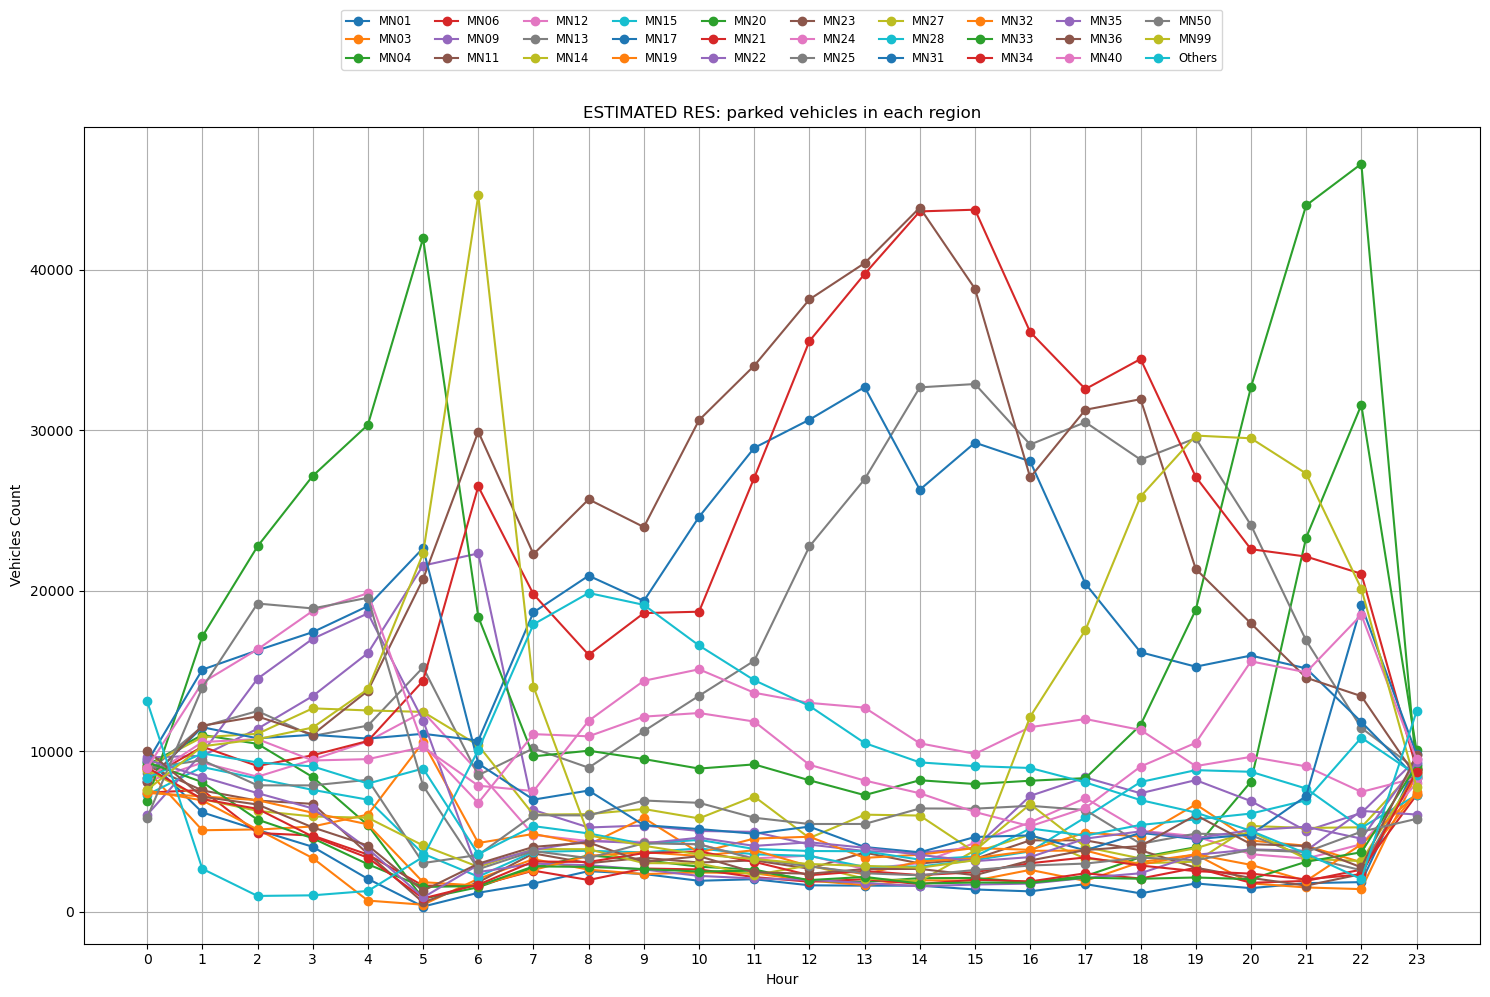

In [30]:
plots_reg_veh(mod_vehicles, 'parked')

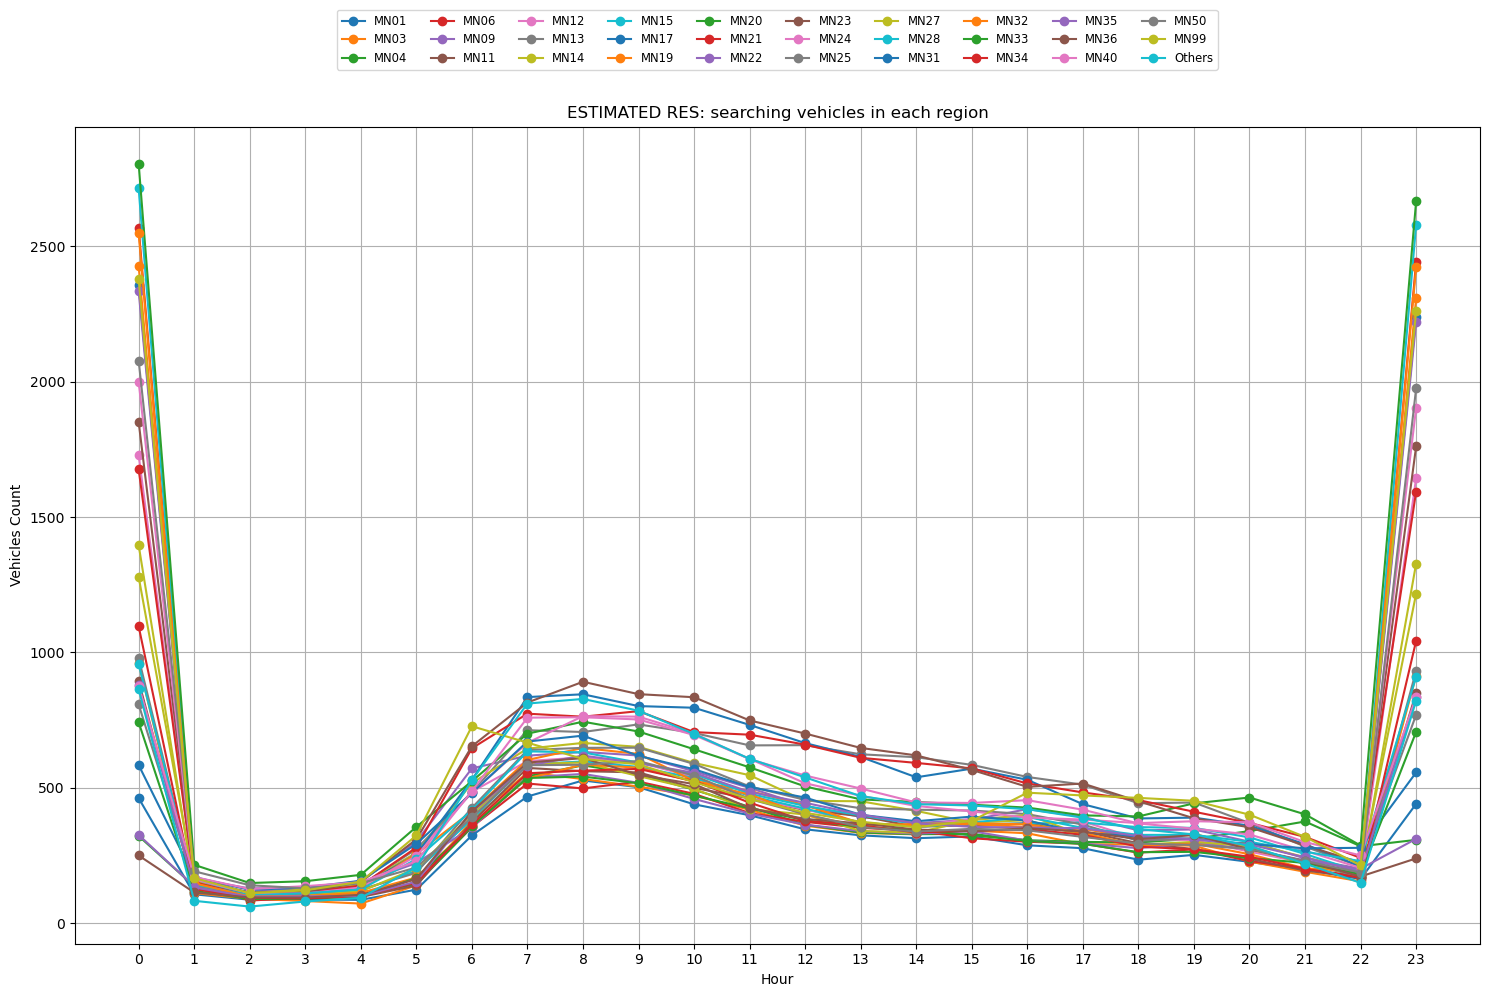

In [31]:
plots_reg_veh(mod_vehicles, 'searching')

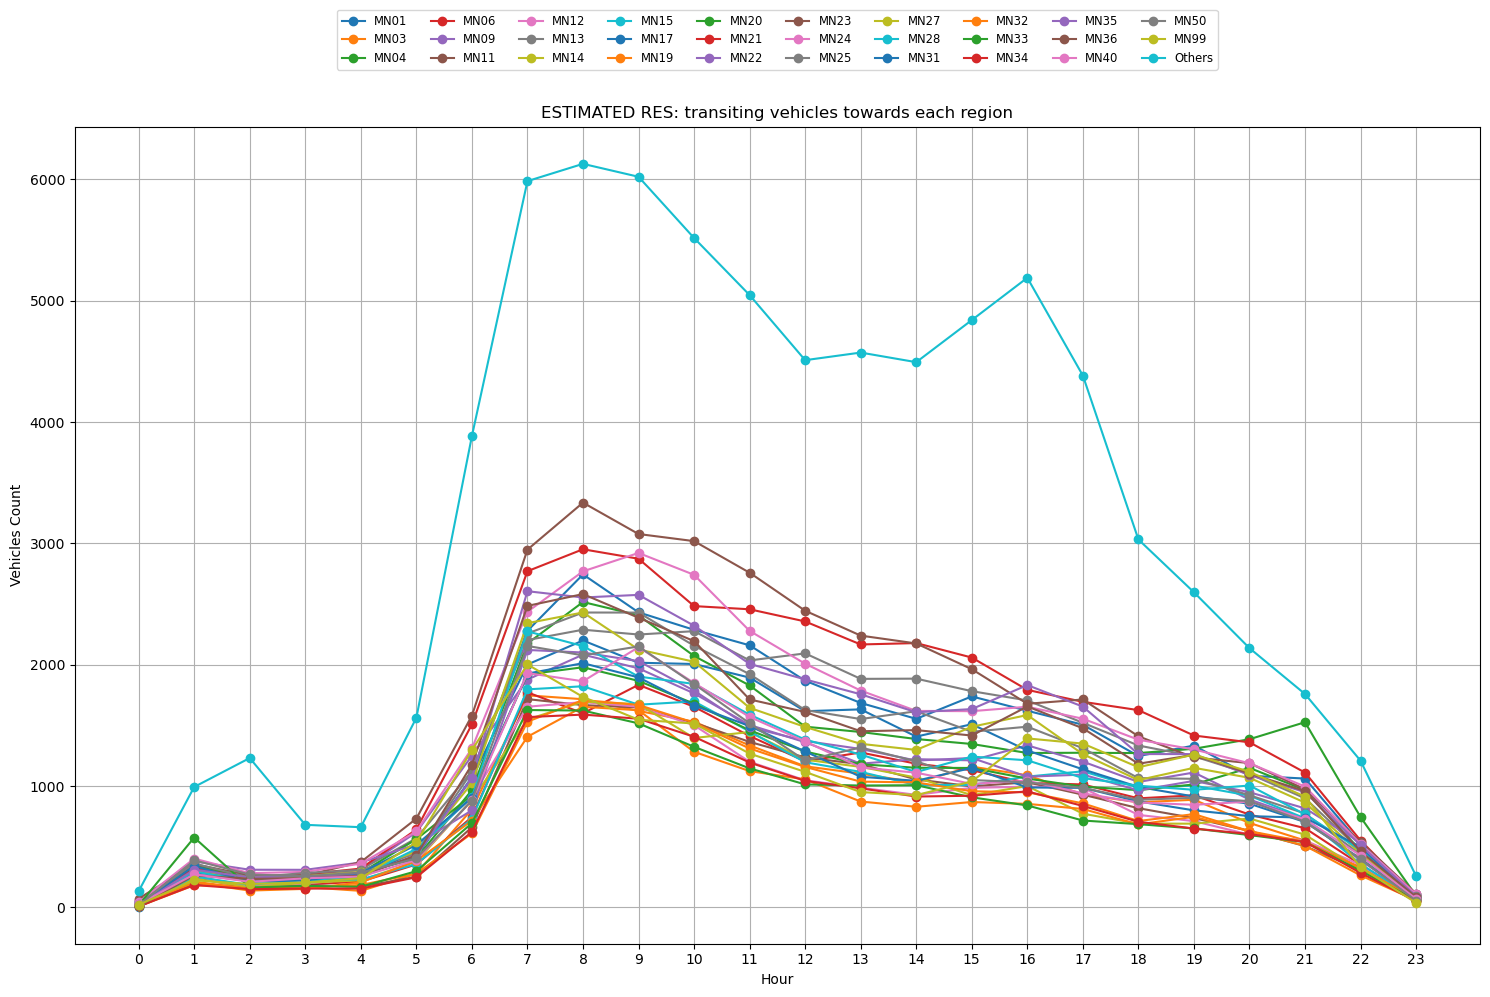

In [32]:
plots_reg_veh(mod_vehicles, 'transiting')

### 7.2 vehicles parked in regular and charging parking lots

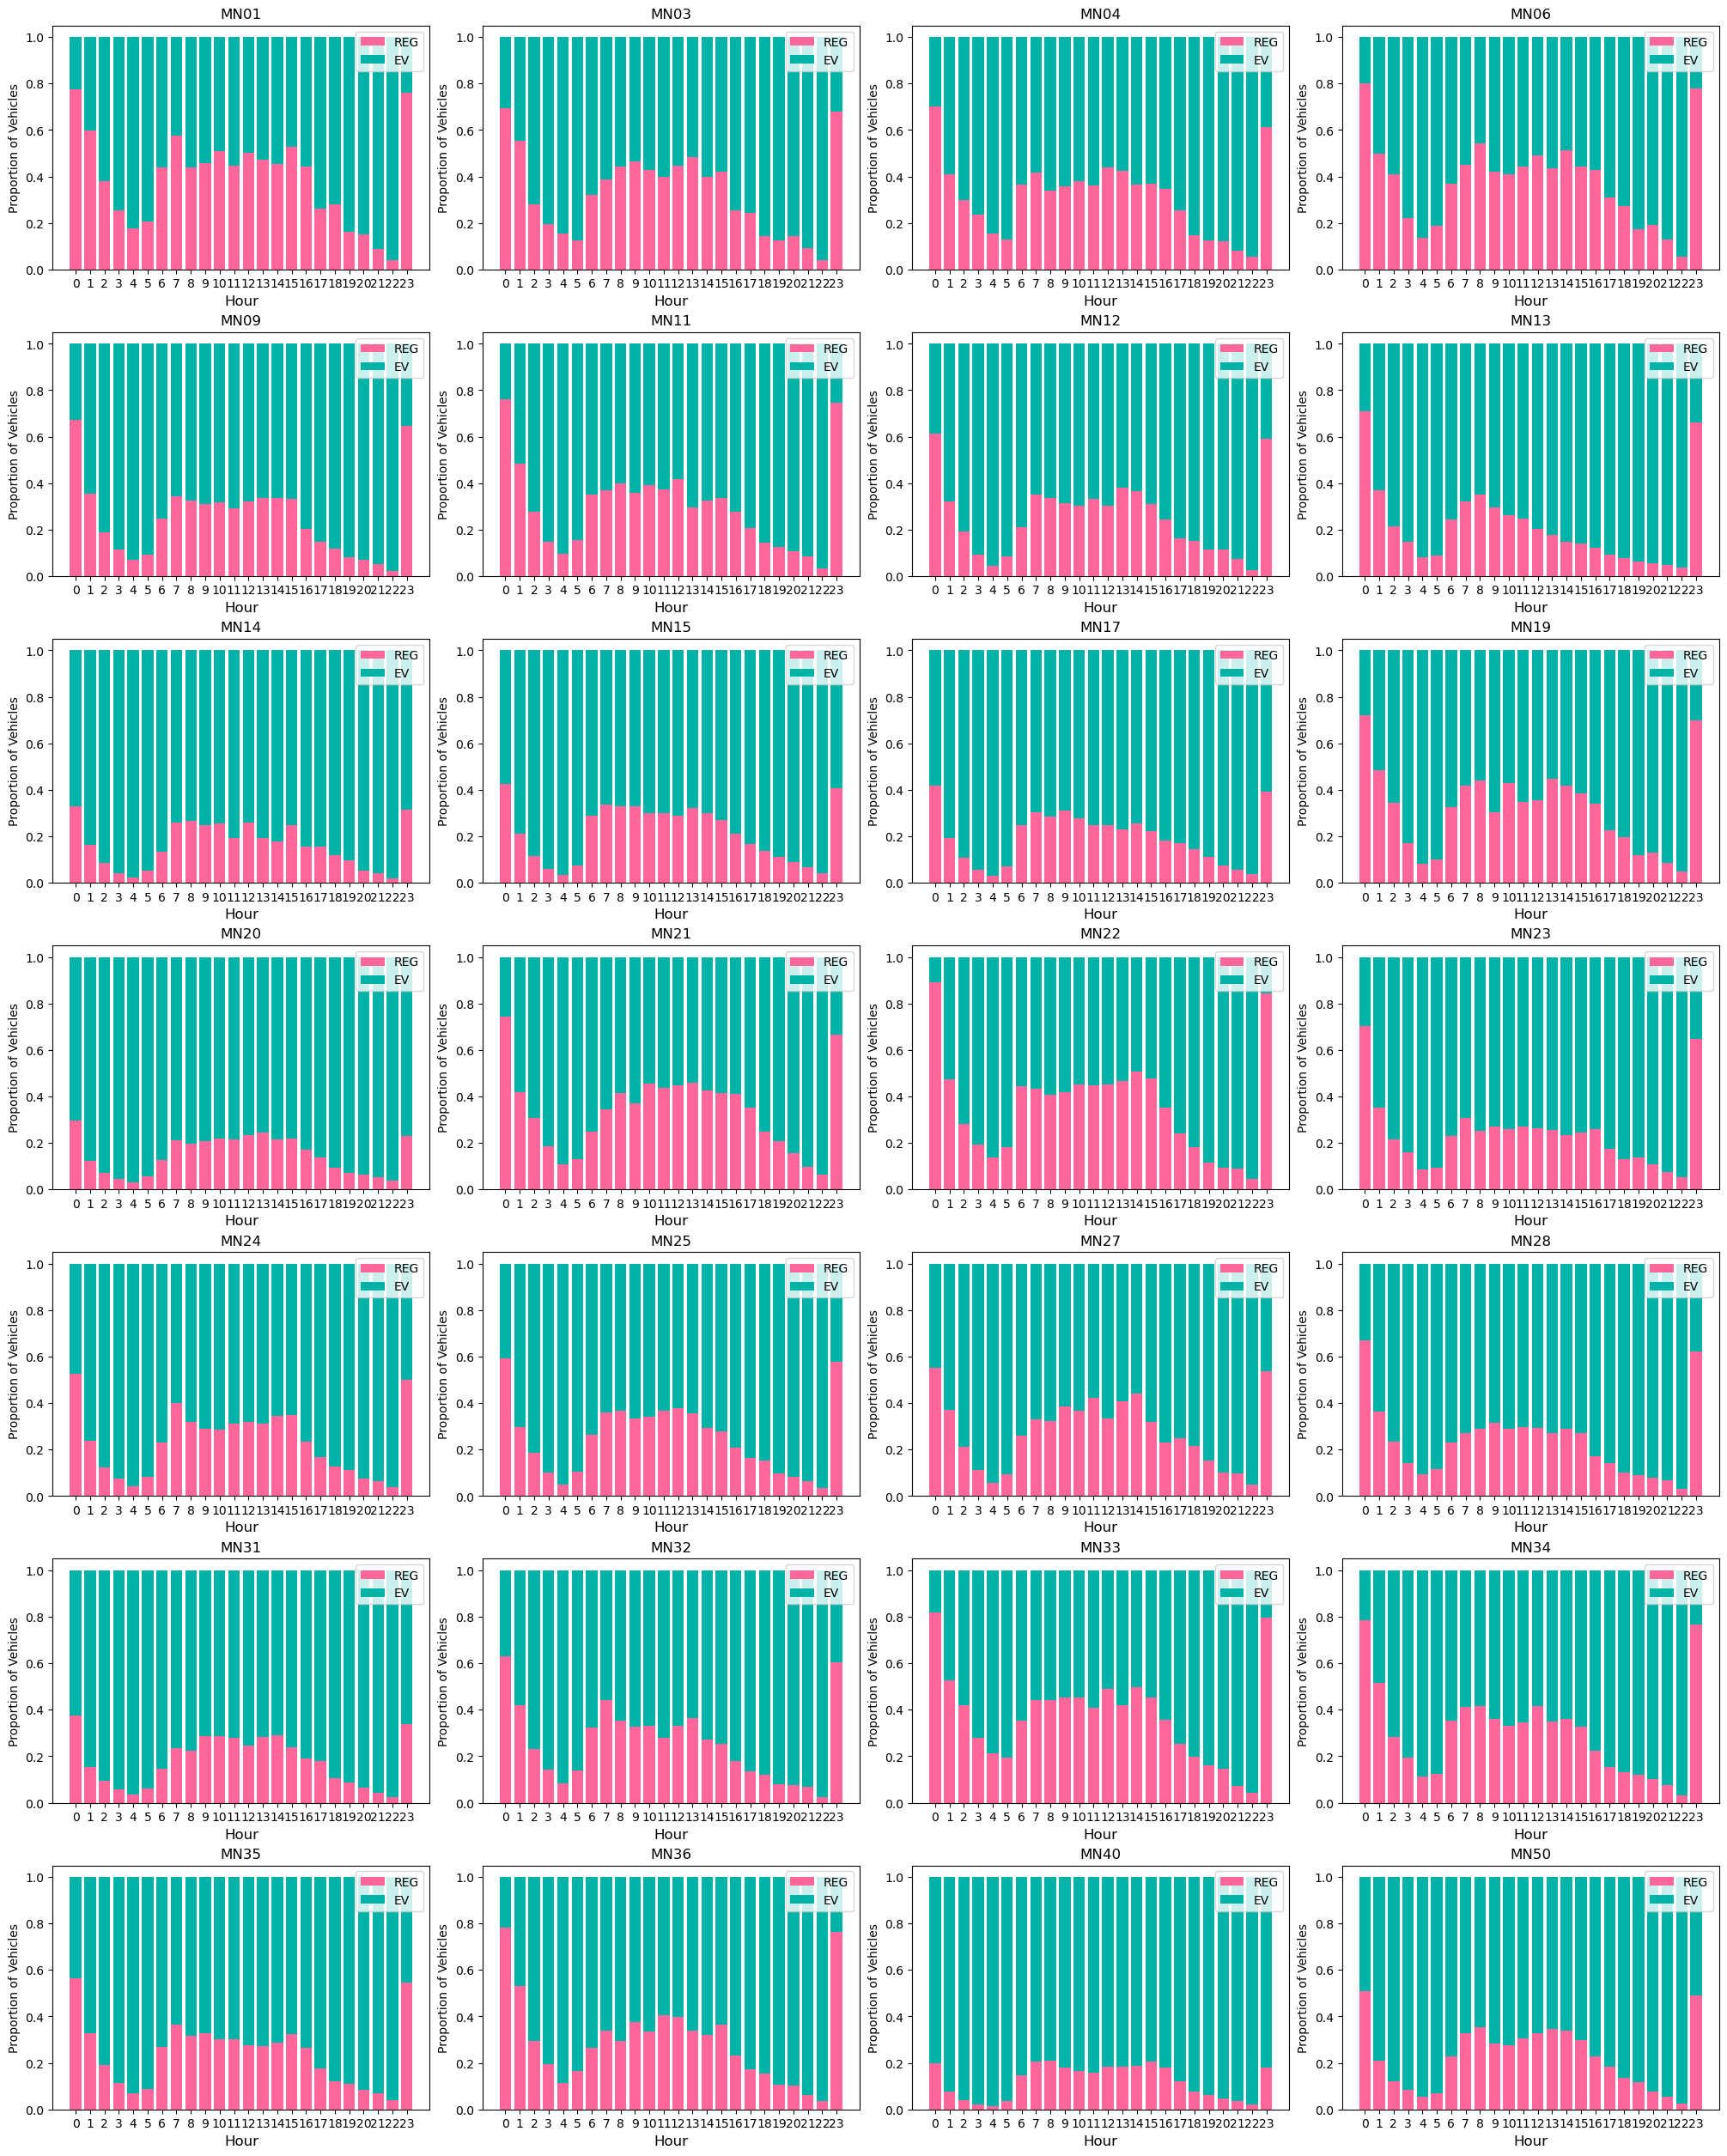

In [9]:
# Assuming REGIONS, STATES, mod_vehicles, and reverse_nta_dict are already defined
region_colors = {region: 'grey' for region in REGIONS}

# Set up the subplots with 7 rows and 4 columns
fig, axs = plt.subplots(7, 4, figsize=(20, 25), constrained_layout=True)  # Adjusted figsize for better readability

# Flatten the 2D array of axes to simplify the loop
axs = axs.flatten()

# Loop through the regions and create the plots
for idx, ii in enumerate(REGIONS[:-2]):
    ev_proportions = []
    reg_proportions = []

    for state in STATES:
        ev_count = mod_vehicles[state]['parked']['EV'][ii]
        reg_count = mod_vehicles[state]['parked']['REG'][ii]
        total = ev_count + reg_count
        
        # Calculate the proportion of EVs and Regular vehicles
        ev_proportions.append(ev_count / total if total != 0 else 0)
        reg_proportions.append(reg_count / total if total != 0 else 0)

    # Define colors for EV and REG
    ev_color = cmaps.get_cmap('winter')(0.7)
    reg_color = cmaps.get_cmap('spring')(0.4)
    
    # Plot the stacked bar chart in the respective subplot
    axs[idx].bar(STATES, reg_proportions, label=f'REG', color=reg_color)
    axs[idx].bar(STATES, ev_proportions, bottom=reg_proportions, label=f'EV', color=ev_color)
    
    axs[idx].set_xticks(STATES)
    axs[idx].set_xlabel('Hour', fontsize=12)
    axs[idx].set_ylabel('Proportion of Vehicles')
    axs[idx].set_title(f'{reverse_nta_dict[ii]}')
    axs[idx].legend()

# Hide any unused subplots (if there are fewer than 28 regions)
for ax in axs[len(REGIONS):]:
    ax.axis('off')
plt.savefig(f'data/data/figures/hourly_parking_proportions.png', dpi=300, bbox_inches='tight')
plt.show()